In [1]:
import os
import numpy as np
import pandas as pd
import dask
import dask.array as da
import dask.dataframe as dd

from hist import Hist

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

In [3]:
import multiprocessing.popen_spawn_posix
from dask.distributed import Client, LocalCluster

#cluster = LocalCluster(n_workers=6, 
#                       threads_per_worker=1,
#                       memory_limit='5Gb')
#client = Client(cluster)

dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
client = Client(scheduler_file='/global/cscratch1/sd/cwalter/dask-mpi/scheduler.json')

client

Client Scheduler: tcp://10.128.0.82:46473 Dashboard: /user/cwalter/cori-shared-node-cpu/proxy/10.128.0.82:43361/status,Cluster Workers: 159 Cores: 159 Memory: 2.52 TB


In [4]:
from functools import wraps

def dask_hist(func):
    
    @wraps(func)
    def send_to_dask(dataframe):
        return dask.dataframe.map_partitions(func, dataframe).compute().sum()

    return send_to_dask

def profile_plot(func):

    @wraps(func)
    def create_plot(*args, **kwargs):
        
        dask_histogram = func(*args)
        centers = dask_histogram.axes.centers[0]
 
        results = dask_histogram.view()
        mean = results.value
        error_on_mean = np.sqrt(results.variance/results.count)  
        
        ax=kwargs.pop('ax', None)
        if ax is None:
            ax = plt.gca()
 
        return ax.errorbar(x=centers, y=mean, yerr=error_on_mean, fmt = '.', markersize=3, **kwargs)

    return create_plot

In [5]:
scratch= os.environ["SCRATCH"]
#scratch = '/Users/walter/LSST/work'

#selected=['id', 'mag_r', 'g1', 'g2', 'e1','e2']
selected = ['id', 'mag_r', 'z', 'ra', 'dec', 'g1', 'g2']

#df = pd.read_parquet('shear-matched.parquet')#.dropna()
#df = dd.read_parquet(f'{scratch}/parquet-cosmoDC2/shear-cosmoDC2-*.parquet', columns=selected)
#df = dd.read_parquet(f'{scratch}/parquet-skysim-small/*.parquet', columns=selected, engine='pyarrow')
df = dd.read_parquet(f'{scratch}/parquet-skysim/*.parquet', columns=selected, engine='pyarrow')
#df = dd.read_parquet(f'{scratch}/skysim-sampled', columns=selected, engine='pyarrow')
df = df.persist()

print('Columns:', df.columns.values, '#Rows:', df.z.size.compute()/1e9)

Columns: ['id' 'mag_r' 'z' 'ra' 'dec' 'g1' 'g2'] #Rows: 6.263019986


In [6]:
%%script false

scratch= os.environ["SCRATCH"]

selected=['galaxy_id', 'mag_r', 'redshift_true', 'ra', 'dec', 'shear_1', 'shear_2']
rename_map ={'galaxy_id':'id', 'mag_r':'mag_r', 'redshift_true':'z', 'ra':'ra', 'dec':'dec', 'shear_1':'g1', 'shear_2':'g2'}

df = dd.read_parquet(f'/global/cfs/cdirs/lsst/shared/xgal/cosmoDC2/cosmoDC2_v1.1.4_parquet/*',columns=selected, engine='pyarrow')
df = df.rename(columns=rename_map)
df = df.query('mag_r < 29')
print('Columns:', df.columns.values, '#Rows:', df.ra.size.compute()/1e9)

In [7]:
print(f'g1 mean = {df.g1.mean().compute():.6f}')
print(f'g2 mean = {df.g2.mean().compute():.6f}')

g1 mean = 0.000453
g2 mean = -0.000039


In [28]:
# Create some histograms functions to book and fill.

@dask_hist
def hist_z(df):

    h = Hist.new.Reg(50, 0, 3).Double()
    h.fill(df.z)
    return h

@profile_plot
@dask_hist
def hist_g1_prof(df):

    h = Hist.new.Reg(50, -0.05, 0.05).Mean()
    h.fill(df.g2, sample=df.g1)
    return h

@profile_plot
@dask_hist
def hist_g1_z_prof(df):

    h = Hist.new.Reg(50, 0, 3).Mean()
    h.fill(df.z, sample=df.g1)
    return h

@profile_plot
@dask_hist
def hist_g2_z_prof(df):

    h = Hist.new.Reg(50, 0, 3).Mean()
    h.fill(df.z, sample=df.g2)
    return h

In [9]:
hist_z(df)

Hist(Regular(50, 0, 3, label='Axis 0'), storage=Double()) # Sum: 6212183293.0 (6263019986.0 with flow)

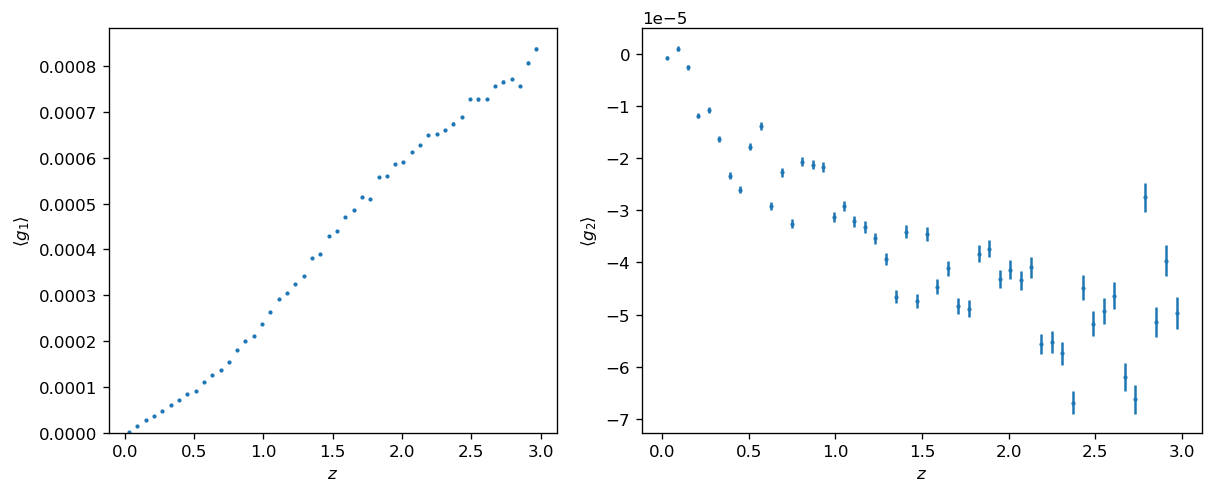

In [10]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[0.8, 1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

hist_g1_z_prof(df, ax=ax0)

ax0.set_ylim(bottom=0)
ax0.set_xlabel(r'$z$')
ax0.set_ylabel(r'$\langle g_1 \rangle$')

hist_g2_z_prof(df, ax=ax1)

ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\langle g_2 \rangle$');

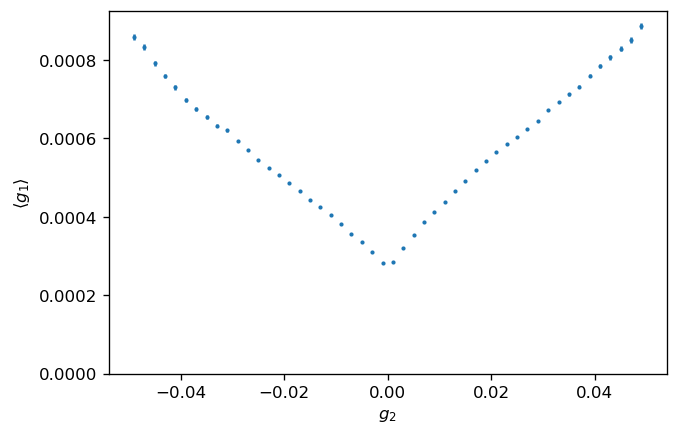

In [11]:
hist_g1_prof(df)

plt.ylim(bottom=0)
plt.xlabel(r'$g_2$')
plt.ylabel(r'$\langle g_1 \rangle$');

In [12]:
%%script false

@profile_plot
@dask_hist
def hist_g1_prime_prof(df):
    
    h = Hist.new.Reg(50, -0.05, 0.05).Mean()
    h.fill(df.g2, sample=df.g1_prime)
    return h

slope_g1 = .00085/3 # <g1>/z
slope_g2 = -7e-5/3 # <g2>/z

df['g2_prime'] = df.g2 - slope_g2*df.z
df['g1_prime'] = df.g1 - slope_g1*df.z

hist_g1_prof(df, label=r'$\langle g_1 \rangle$')
hist_g1_prime_prof(df, label=r'$\langle g^{\prime}_1 \rangle$')

plt.legend()
plt.title('$g_1$ Profile Histogram')
plt.xlabel(r'$g_2$')
plt.ylabel(r'$\langle g_1 \rangle$')

In [13]:
@dask_hist
def dask_heatmap(df):
    
    h = Hist.new.Reg(50, 0, 3, name='Redshift', label='z').Reg(50, -0.03, 0.03, name='$g_1$').Double()
    h.fill(df.z, df.g1)
    return h

In [14]:
%%script false

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

heatmap = dask_heatmap(df)

values= heatmap.view()
x = heatmap.axes[0].edges
y = heatmap.axes[1].edges

heat_opts = opts.HeatMap(tools=['hover'], colorbar=True, width=700, height=500, cformatter='%2.0e', cmap='Viridis', xlabel='z', ylabel='g1')
hv.HeatMap((x, y, values.T)).opts(heat_opts)

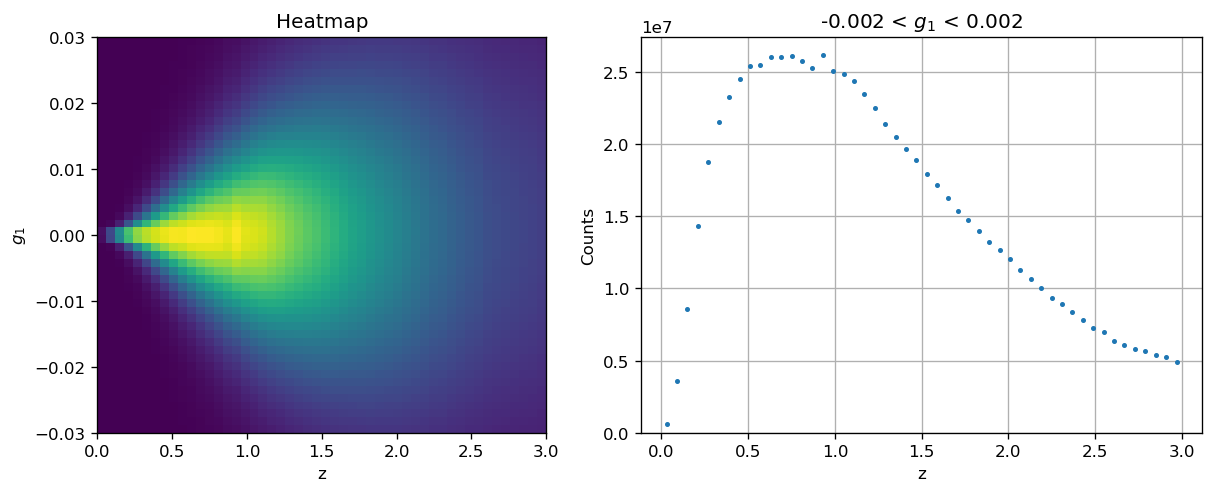

In [15]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[0.8, 1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

dask_heatmap(df).plot(ax=ax0, cbar=False)
ax0.set_title('Heatmap')

hist_z(df.query('-0.002 < g1 < 0.002')).plot(ax=ax1, histtype='errorbar', markersize=4)
ax1.set_xlabel('z')
ax1.set_ylabel('Counts')
ax1.set_title('-0.002 < $g_1$ < 0.002')
ax1.grid(True)

In [16]:
@dask_hist
def g1_slice(selected):
    
    h = Hist.new.Reg(50, -0.1, 0.1).Double()
    h.fill(selected.g1)
    return h

g1_slice(df.query('z>2.95'))

Hist(Regular(50, -0.1, 0.1, label='Axis 0'), storage=Double()) # Sum: 119803761.0 (120115038.0 with flow)

In [17]:
@dask_hist
def sky_blocks(df):
    
    h = Hist.new.Reg(3, 0, 90, name='RA').Reg(3, -90, 0, name='Dec').Reg(50, 0, 3, name='Redshift').Mean()
    h.fill(df.ra, df.dec, df.z, sample=df.g1)
    return h

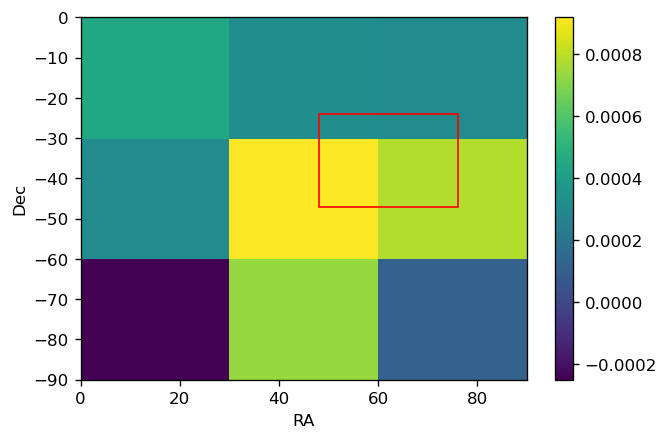

In [18]:
blocks_2d = sky_blocks(df).project('RA','Dec');

mean_2d = blocks_2d.view().value
x = blocks_2d.axes[0].edges
y = blocks_2d.axes[1].edges
plt.pcolormesh(x, y, mean_2d.T)

plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')

import matplotlib.patches as patches
currentAxis = plt.gca()
cosmoDC2 = patches.Rectangle((48,-47),28,23,linewidth=1,edgecolor='r',facecolor='none')
currentAxis.add_patch(cosmoDC2);

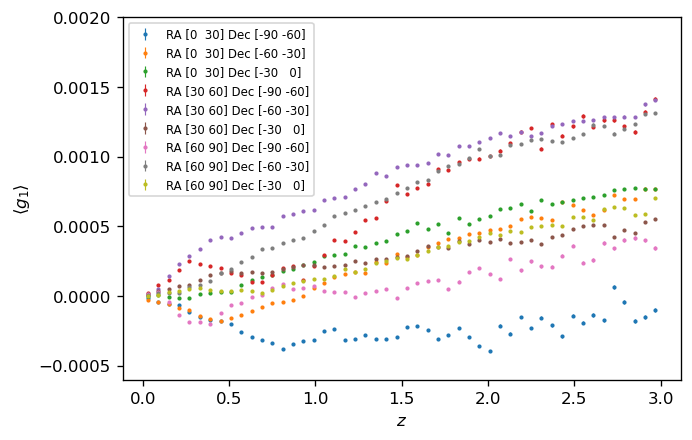

In [19]:
blocks = sky_blocks(df)
ra_dec_axes = blocks[:,:,0].axes

for index in np.ndindex(3, 3):

    bin = ra_dec_axes.bin(*index)
    label = f'RA [{bin[0][0]:<2.0f} {bin[0][1]:>2.0f}] Dec [{bin[1][0]:<3.0f} {bin[1][1]:>3.0f}]'
    
    patch = blocks[index[0], index[1], :]
    centers = patch.axes.centers[0]
    mean = patch.view().value
    error_on_mean = np.sqrt(patch.view().variance/patch.view().count) 
    
    plt.errorbar(x=centers, y=mean, yerr=error_on_mean, fmt = '.', markersize=3, elinewidth=.7, label=label)
    
plt.ylim(bottom=-.0006, top=.0020);
plt.legend(prop={'size': 7})
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle g_1 \rangle$');

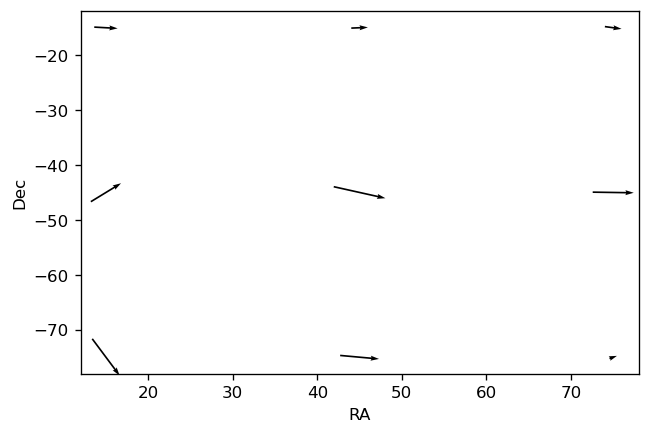

In [27]:
binning = 3

@dask_hist
def mean_g1(df):
    
    h = Hist.new.Reg(binning, 0, 90, name='RA').Reg(binning, -90, 0, name='Dec').Mean()
    h.fill(df.ra, df.dec, sample=df.g1)
    return h

@dask_hist
def mean_g2(df):
    
    h = Hist.new.Reg(binning, 0, 90, name='RA').Reg(binning, -90, 0, name='Dec').Mean()
    h.fill(df.ra, df.dec, sample=df.g2)
    return h

g1_hist = mean_g1(df)
g2_hist = mean_g2(df)

x_centers = g1_hist.axes[0].centers
y_centers = g1_hist.axes[1].centers

g1 = g1_hist.view().value
g2 = g2_hist.view().value

reduced_shear = g1 + g2*1j
magnitude = np.abs(reduced_shear.T)
phi = np.angle(reduced_shear.T)/2

plt.quiver(x_centers, y_centers, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid', width=.003)
plt.xlabel('RA')
plt.ylabel('Dec');

In [21]:
%%script false

client.cancel(df)
client.restart();